In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from ucsd_dataset import UCSDAnomalyDataset
from video_CAE import VideoAutoencoderLSTM
import torch.backends.cudnn as cudnn
import numpy as np
#matplotlib notebook
import matplotlib.pyplot as plt

Training hyperparameters are the same as in https://github.com/hashemsellat/Video-Anomaly-Detection/blob/master/lstmautoencoder.ipynb (except for few more epochs).

In [ ]:
model = VideoAutoencoderLSTM()
criterion = nn.MSELoss()

use_cuda = torch.cuda.is_available()
if use_cuda:
    cudnn.benchmark = True
    model.set_cuda()
    criterion.cuda()
    
train_ds = UCSDAnomalyDataset('./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train', time_stride=3)
train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-6, weight_decay=1e-5)

model.train()
for epoch in range(5):
    for batch_idx, x in enumerate(train_dl):
        optimizer.zero_grad()
        if use_cuda:
            x = x.cuda()
        y = model(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Epoch {}, iter {}: Loss = {}'.format(
            epoch, batch_idx, loss.item()))
    torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()},
        './snapshot/checkpoint.epoch{}.pth.tar'.format(epoch))

Inference on test samples (Test001 and Test032)

In [2]:
model = VideoAutoencoderLSTM()
model.load_state_dict(torch.load('./snapshot/checkpoint.epoch4.pth.tar')['state_dict'])
model.set_cuda()
model.eval()

VideoAutoencoderLSTM(
  (conv_encoder): Sequential(
    (conv1): Conv2d(1, 128, kernel_size=(11, 11), stride=(4, 4))
    (nonl1): Tanh()
    (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (nonl2): Tanh()
  )
  (rnn_enc_dec): ConvLSTM(
    (_all_layers): ModuleList(
      (0): ConvLSTMCell(
        (input_dropout): Dropout(p=0.5, inplace=False)
        (reccurent_drouput): Dropout(p=0.5, inplace=False)
        (Wxi): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whi): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxf): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whf): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxc): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whc): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxo): Conv2d(64, 64, kernel_size=(3, 3), stride

In [3]:
test_ds = UCSDAnomalyDataset('./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/inference')
test_dl = data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [4]:
frames = []
errors = []
for batch_idx, x in enumerate(test_dl):
    y = model(x.cuda())
    mse = torch.norm(x.cpu().data.view(x.size(0),-1) - y.cpu().data.view(y.size(0),-1), dim=1)
    errors.append(mse)
errors = torch.cat(errors).numpy()

In [5]:
errors = errors.reshape(-1, 191)
s = np.zeros((2,191))
s[0,:] = 1 - (errors[0,:] - np.min(errors[0,:]))/(np.max(errors[0,:]) - np.min(errors[0,:]))
s[1,:] = 1 - (errors[1,:] - np.min(errors[1,:]))/(np.max(errors[1,:]) - np.min(errors[1,:]))

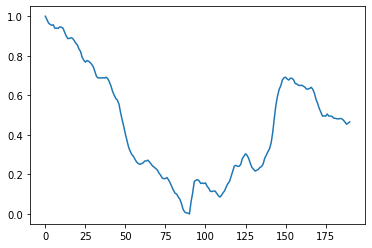

In [6]:
# Test001
plt.plot(s[0,:])
plt.show()

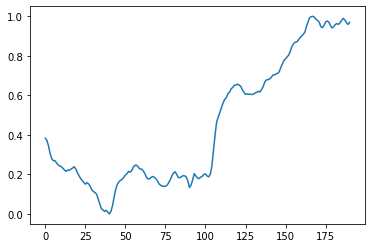

In [7]:
# Test032
plt.plot(s[1,:])
plt.show()